# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>

On commence par importer les différents fichiers utiles pour implémenter le solveur SPH

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *

Définition des paramètres

In [2]:
#GEOMETRIC PARAMETERS
L = 1 #m
U = 1 # Upper bound velocity
Re = 1
#FLUID PARAMETERS
rhoF = 1000
c0 = 40
mu = rhoF*U*L/Re #(Pa.s)
print(mu)
grav = np.array([0.0, 0.0]) #m.s-2
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF

1000.0


In [3]:
#PARTICLES & SPACES PARAMETERS : 
dr = L/40
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
print(lspace)
#COMPUTATION DOMAIN : 
xOrigin = 0
yOrigin = 0
xSize = L + 2*nBound*dr
ySize = L+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize

0.1


Les FLAGs sont définis dans le fichier [src/sphvar.py](src/sphvar.py)

Les murs seront composés d'une couche de *nBound =4* particules *fictives*. Ce nombre est suffisant pour éviter la pénétration du mur.

Pour ajouter des particules au tableau *part*, utilisez la fonction *addBox* :

```python
part = addBox(part,[x_0,y_0,L_x,L_y],FLAG,dr,rhoF)
```

cette commande ajoute à part des particules de type FLAG dans le domaine rectangulaire : $\left[x_0,x_0+L_x\right]\times\left[y_0,y_0+L_y\right]$

In [4]:
#INIT PART:
part = init_particles()
part = addBox(part,[0,0,xSize,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[0, nBound*dr, nBound*dr,L], BOUND, dr, rhoF)
part = addBox(part,[nBound*dr+L, nBound*dr, nBound*dr,L], BOUND, dr, rhoF)
part = addBox(part,[0, nBound*dr+L, xSize,nBound*dr], MOBILEBOUND, dr, rhoF)#mobile parts --> à voir si on fait un flag spécifique 

part = addBox(part,[nBound*dr,nBound*dr,L,L],FLUID,dr,rhoF)

In [5]:
len(part)

2304

On doit trouver 4624 particules

<IPython.core.display.Javascript object>


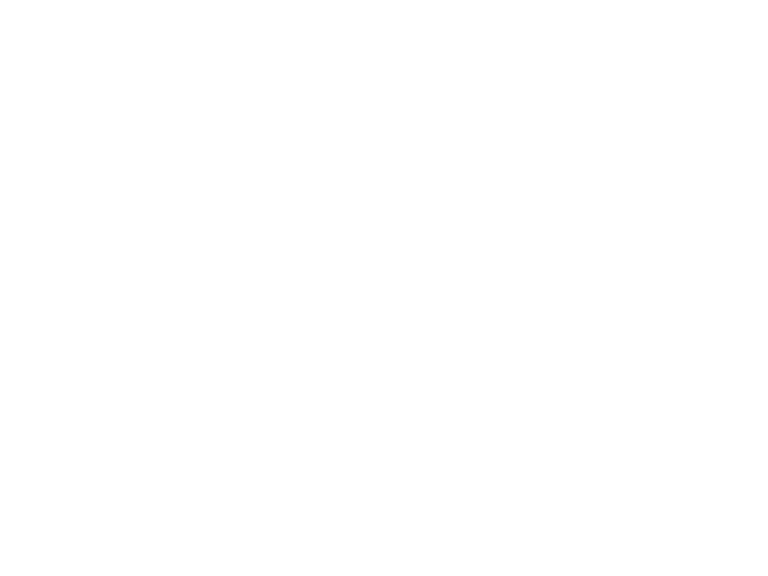

In [6]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [7]:
vecPer = np.array([12*lspace,0])
posSpace,neibSpace,partSpace,listNeibSpace = init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
plotSpaces(posSpace,'k',lspace,1)

In [8]:
part[:,VEL] = initMobileBoundVelocity((part[:,INFO]==MOBILEBOUND), part[:,VEL], U)

In [9]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Cavity_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [10]:
# Here we specify the output frequencies
dt_figure = 0.025*(L/2)**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0


time :
0.00012195121951219515


<IPython.core.display.Javascript object>


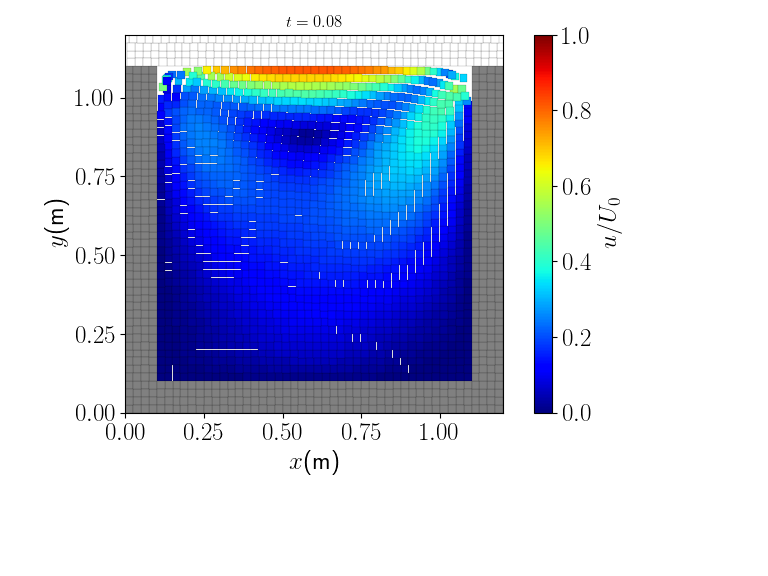

time :
0.00024099883855981422
time :
0.0003600464576074333
time :
0.0004790940766550524
time :
0.0005981416957026715
time :
0.0007171893147502906
time :
0.0008362369337979097
time :
0.0009552845528455288
time :
0.0010743321718931478
time :
0.001193379790940767
time :
0.001312427409988386
time :
0.0014314750290360051
time :
0.0015505226480836242
time :
0.0016695702671312433
time :
0.0017886178861788624
time :
0.0019076655052264815
time :
0.0020267131242741004
time :
0.0021457607433217193
time :
0.002264808362369338
time :
0.002383855981416957
time :
0.002502903600464576
time :
0.002621951219512195
time :
0.0027409988385598137
time :
0.0028600464576074326
time :
0.0029790940766550515
time :
0.0030981416957026704
time :
0.0032171893147502893
time :
0.003336236933797908
time :
0.003455284552845527
time :
0.003574332171893146
time :
0.003693379790940765
time :
0.0038124274099883837
time :
0.003931475029036003
time :
0.004050522648083622
time :
0.004169570267131242
time :
0.00428861788617886

time :
0.035479094076655
time :
0.03559814169570261
time :
0.03571718931475023
time :
0.035836236933797845
time :
0.03595528455284546
time :
0.03607433217189308
time :
0.03619337979094069
time :
0.03631242740998831
time :
0.036431475029035924
time :
0.03655052264808354
time :
0.036669570267131156
time :
0.03678861788617877
time :
0.03690766550522639
time :
0.037026713124274004
time :
0.03714576074332162
time :
0.037264808362369235
time :
0.03738385598141685
time :
0.03750290360046447
time :
0.03762195121951208
time :
0.0377409988385597
time :
0.037860046457607315
time :
0.03797909407665493
time :
0.038098141695702546
time :
0.03821718931475016
time :
0.03833623693379778
time :
0.038455284552845394
time :
0.03857433217189301
time :
0.038693379790940625
time :
0.03881242740998824
time :
0.03893147502903586
time :
0.03905052264808347
time :
0.03916957026713109
time :
0.039288617886178705
time :
0.03940766550522632
time :
0.039526713124273936
time :
0.03964576074332155
time :
0.03976480836

time :
0.0715505226480826
time :
0.07166957026713022
time :
0.07178861788617784
time :
0.07190766550522545
time :
0.07202671312427307
time :
0.07214576074332069
time :
0.0722648083623683
time :
0.07238385598141592
time :
0.07250290360046353
time :
0.07262195121951115
time :
0.07274099883855877
time :
0.07286004645760638
time :
0.072979094076654
time :
0.07309814169570161
time :
0.07321718931474923
time :
0.07333623693379684
time :
0.07345528455284446
time :
0.07357433217189208
time :
0.07369337979093969
time :
0.07381242740998731
time :
0.07393147502903492
time :
0.07405052264808254
time :
0.07416957026713016
time :
0.07428861788617777
time :
0.07440766550522539
time :
0.074526713124273
time :
0.07464576074332062
time :
0.07476480836236823
time :
0.07488385598141585
time :
0.07500290360046347
time :
0.07512195121951108
time :
0.0752409988385587
time :
0.07536004645760631
time :
0.07547909407665393
time :
0.07559814169570155
time :
0.07571718931474916
time :
0.07583623693379678
time :
0

In [ ]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] =interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileBoundary((part[:,INFO]==MOBILEBOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     np.array([U, 0.0]),\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt)
    #STEP4BIS : integration en temps des particules de la paroi mobile
    part[:,POS], part[:,RHO] = integrationStepPeriodicX_Moving_BoundCavity((part[:,INFO]==MOBILEBOUND),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    print("time :")
    print(t)
    it +=1
    if t>=t_print:
        #FIGURE 1
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t = %2.2f$'%(t))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$u/U_0$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)

            
        im_count = im_count+1
        t_print +=dt_figure
        